In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('complete_hinglish_sentiment.csv', sep=",")
df.head()

,en,hinglish,label,hinglish_clean,label_encoded
0,Batman vs Superman,batman vs superman,neutral,batman vs superman,1
1,"The director is Zack Snyder , 27 % Rotten Toma...","Zack Snyder director हैं , 27 % Rotten Tomatoe...",neutral,zack snyder director हैं rotten tomatoes,1
2,Not very popular it seems,लगता है बहुत popular नहीं है,negative,लगता है बहुत popular नहीं है,0
3,But the audiences liked it . It has a B cinema...,"but audience ने like किया , इसका cinema score ...",positive,but audience ने like किया इसका cinema score भी है,2
4,Yes,yes,neutral,yes,1


In [10]:
df.isna().sum()

en                 0
hinglish           0
label              0
hinglish_clean    32
label_encoded      0
dtype: int64

In [11]:
df['hinglish_clean'].fillna(" ", inplace=True)

In [12]:
df.isna().sum()

en                0
hinglish          0
label             0
hinglish_clean    0
label_encoded     0
dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['hinglish_clean'], df['label_encoded'], 
    test_size=0.25, random_state=42, stratify=df['label_encoded']
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6751,) (2251,)
(6751,) (2251,)


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fit tokenizer on full vocab
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [15]:
!pip install -q keras-tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
def model_builder(hp):
    model = Sequential()
    
    hp_vocab_size = hp.Choice('vocab_size', [5000, 10000, 20000])
    hp_embed_dim = hp.Choice('embedding_dim', [64, 128, 256])
    
    model.add(Embedding(
        input_dim=hp_vocab_size,  # cutoff applied here
        output_dim=hp_embed_dim,
        input_length=50
    ))
    
    hp_lstm_units = hp.Choice('lstm_units', [64, 128, 256])
    hp_lstm_dropout = hp.Float('lstm_dropout', 0.2, 0.5, step=0.1)
    model.add(Bidirectional(LSTM(hp_lstm_units, dropout=hp_lstm_dropout)))
    
    num_dense_layers = hp.Choice('num_dense_layers', [1, 3, 5, 7, 9, 11])
    for i in range(num_dense_layers):
        units = hp.Choice(f'dense_units_{i}', [32, 64, 128])
        dropout = hp.Float(f'dense_dropout_{i}', 0.2, 0.5, step=0.1)
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout))
    
    model.add(Dense(3, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 5e-3, 1e-3, 5e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# 1️⃣ Initialize the tuner (you can choose RandomSearch, BayesianOptimization, or Hyperband)
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_accuracy',      # Metric to optimize
    max_trials=15,                 # Number of different combinations to try
    executions_per_trial=1,        # Run each trial once
    directory='tuner_results',     # Folder to save tuning logs
    project_name='hinglish_lstm_tuning'
)

# 2️⃣ Define early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 3️⃣ Run the hyperparameter search
tuner.search(
    X_train_pad, y_train,
    epochs=15,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 4️⃣ Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
✅ Best Hyperparameters Found:
Vocab Size: {best_hps.get('vocab_size')}
Embedding Dim: {best_hps.get('embedding_dim')}
LSTM Units: {best_hps.get('lstm_units')}
LSTM Dropout: {best_hps.get('lstm_dropout')}
Num Dense Layers: {best_hps.get('num_dense_layers')}
Learning Rate: {best_hps.get('learning_rate')}
""")

for i in range(best_hps.get('num_dense_layers')):
    print(f"Dense Layer {i+1} Units: {best_hps.get(f'dense_units_{i}')}, Dropout: {best_hps.get(f'dense_dropout_{i}')}")
# 5️⃣ Build and retrain best model with all data
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 6️⃣ Evaluate on test set
test_loss, test_acc = best_model.evaluate(X_test_pad, y_test)
print(f"🧠 Test Accuracy: {test_acc:.4f}")

# 7️⃣ Save the final tuned model
best_model.save("best_hinglish_lstm_tuned.keras")


Trial 15 Complete [00h 02m 52s]
val_accuracy: 0.7446336150169373

Best val_accuracy So Far: 0.7646188139915466
Total elapsed time: 00h 18m 20s

✅ Best Hyperparameters Found:
Vocab Size: 10000
Embedding Dim: 128
LSTM Units: 256
LSTM Dropout: 0.2
Num Dense Layers: 1
Learning Rate: 0.005

Dense Layer 1 Units: 128, Dropout: 0.4
Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.6319 - loss: 0.8491 - val_accuracy: 0.7387 - val_loss: 0.6630
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7946 - loss: 0.5519 - val_accuracy: 0.7402 - val_loss: 0.6425
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.8839 - loss: 0.3310 - val_accuracy: 0.7461 - val_loss: 0.6847
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9346 - loss: 0.1889 - val_accuracy: 0.7624 - val_loss: 0.8049
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9622 - loss: 0.1191 - val_accuracy: 0.7454 - val_loss: 0.8726
71/71 ━━━━━━━━━━━━━━━━━━

📋 All Tuning Results:
  trial_id  val_accuracy  vocab_size  embedding_dim  lstm_units  lstm_dropout  \
0       01      0.764619       10000            128         256           0.2   
1       02      0.753516       20000            256          64           0.4   
2       09      0.749075       10000             64         256           0.2   
3       03      0.746854       10000            256         256           0.3   
4       08      0.746854       20000            128         128           0.3   
5       14      0.744634       10000            128         256           0.4   
6       11      0.742413       20000            128         128           0.3   
7       07      0.739452       10000             64          64           0.4   
8       00      0.713546       10000            128          64           0.2   
9       04      0.713546       20000            256         128           0.4   

   num_dense_layers  dense_units_0  dense_dropout_0  learning_rate  ...  \
0          

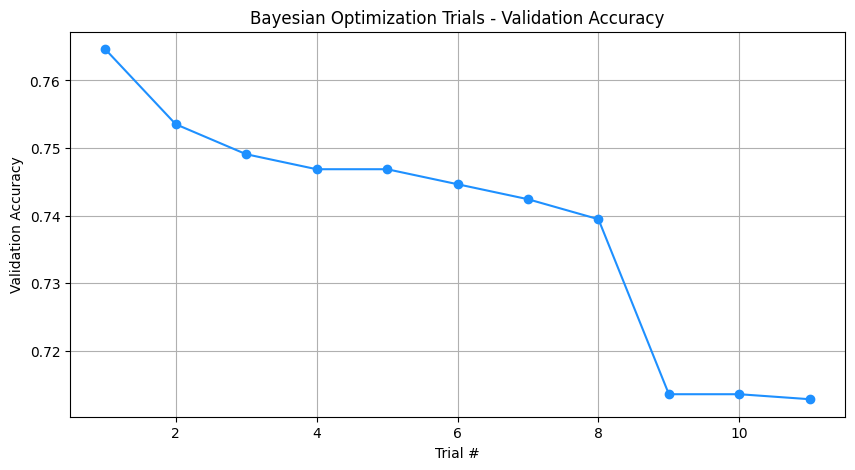

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch summary of all trials
tuner_results = []

for trial in tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials)):
    trial_id = trial.trial_id
    score = trial.score
    params = trial.hyperparameters.values
    tuner_results.append({
        "trial_id": trial_id,
        "val_accuracy": score,
        **params
    })

df_results = pd.DataFrame(tuner_results)
df_results = df_results.sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)

# Display the top results
print("📋 All Tuning Results:")
print(df_results.head(10))

# Plot all trials' validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(df_results.index + 1, df_results["val_accuracy"], marker='o', color='dodgerblue')
plt.title("Bayesian Optimization Trials - Validation Accuracy")
plt.xlabel("Trial #")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


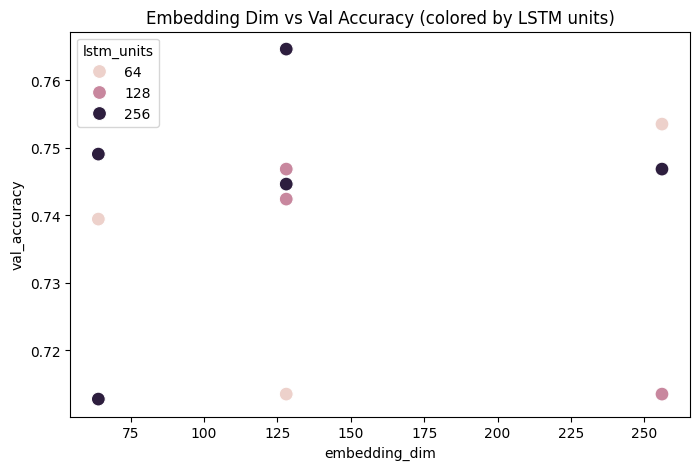

In [25]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(x=df_results['embedding_dim'], y=df_results['val_accuracy'], hue=df_results['lstm_units'], s=100)
plt.title("Embedding Dim vs Val Accuracy (colored by LSTM units)")
plt.show()


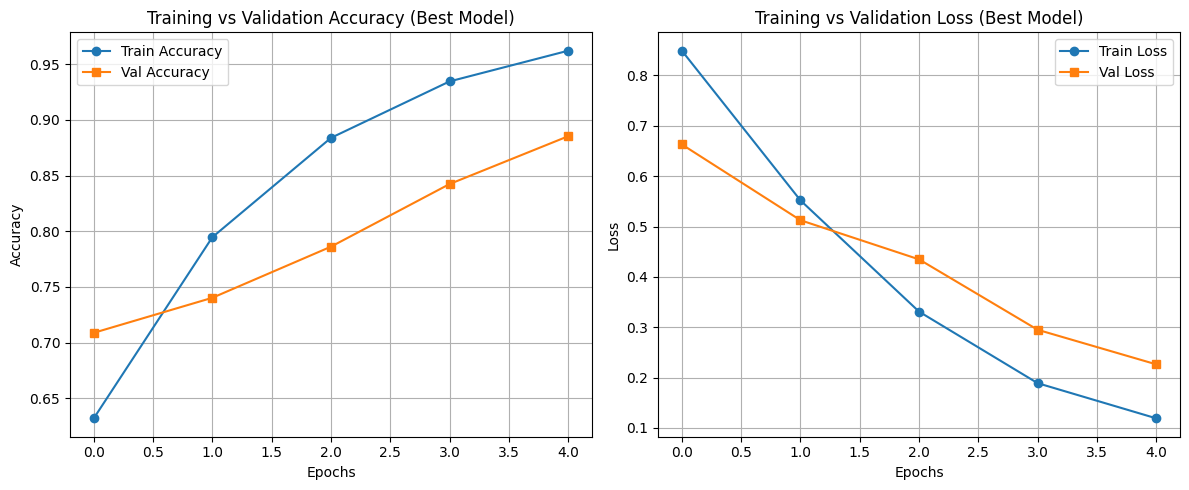

In [33]:
# Plot training vs validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", marker='o')
plt.plot(history.history["val_accuracy"], label="Val Accuracy", marker='s')
plt.title("Training vs Validation Accuracy (Best Model)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", marker='o')
plt.plot(history.history["val_loss"], label="Val Loss", marker='s')
plt.title("Training vs Validation Loss (Best Model)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
